In [1]:
!pip install pandas numpy sklearn matplotlib tensorly openpyxl keras scipy 

In [419]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA, NMF
import tensorly as tl
from tensorly.decomposition import tucker,non_negative_tucker,parafac,non_negative_parafac
from tensorly import tucker_to_tensor
from tensorly.cp_tensor import cp_to_tensor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.integrate as integrate
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

In [4]:
## Import Data here
X=pd.read_excel('Machine_Learning_tutorials\EMG_daven1.xlsx')
Y=pd.read_excel('Machine_Learning_tutorials\trg.xlsx')
print(X)
print(Y)


             FE        BR        BI        TM        TL        AD        PD  \
0      0.050587  0.008961  0.011075  0.010895  0.005528  0.046121  0.026713   
1      0.061057  0.010379  0.013122  0.019175  0.004545  0.056244  0.050764   
2      0.058076  0.010070  0.024306  0.020219  0.004964  0.079270  0.053957   
3      0.034720  0.010632  0.056218  0.014593  0.007750  0.088823  0.041994   
4      0.013102  0.011313  0.105352  0.008760  0.012370  0.080694  0.027843   
...         ...       ...       ...       ...       ...       ...       ...   
31995  0.029656  0.016685  0.069088  0.022464  0.008488  0.044846  0.024668   
31996  0.035597  0.009815  0.052660  0.017385  0.006603  0.026665  0.019428   
31997  0.046430  0.007000  0.034292  0.013352  0.005808  0.016584  0.020196   
31998  0.052863  0.007029  0.025411  0.011540  0.005510  0.014054  0.021418   
31999  0.054463  0.007369  0.023624  0.011147  0.005434  0.013958  0.021777   

             PE        LD  
0      0.010400  0.0120

In [5]:
##Specify the model rank you want to investigate using this variable throughout
num_components=3


In [424]:
##The task variables available here to predict are presented below:
display(Y)

##Select which variable you would like to predict by setting Type=1 for P1-P8 reaching tasks in 
##both forward and backwards directions, set Type=2 for the speed variable and Type=3 for the reaching diretion variable.

Type=2

if Type==1:
    task=Y.iloc[:,0]
elif Type==2:
    task=Y.iloc[:,1]
else:
    task=Y.iloc[:,2]

,TASK,Speed,Direction
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
635,16,1,1
636,16,1,1
637,16,1,1
638,16,1,1


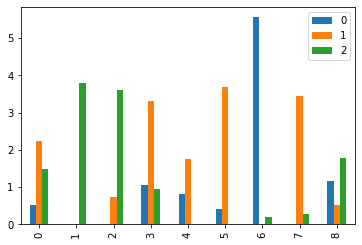

Timepoint specific activation coefficient : [[0.00445753 0.0087293  0.00891719 ... 0.00318417 0.00353221 0.00361545]
 [0.00691987 0.00730602 0.00995962 ... 0.00413595 0.00394586 0.00393877]
 [0.00267341 0.00312425 0.00352195 ... 0.00562449 0.00492552 0.00482269]]


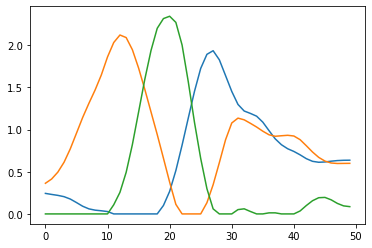

Trial-specific muscle activation coefficient : [[0.09519026 0.01793609 0.01270044 ... 0.02148107 0.00727427 0.00314824]
 [0.05579619 0.02273862 0.07686776 ... 0.04255542 0.00858382 0.01132671]
 [0.09198873 0.01027585 0.03246118 ... 0.03026622 0.0006698  0.01086567]]


In [126]:
##Non-negative matrix factorisation in both the spatial and temporal domains

##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

##Here are the hyperparameters for NNMF that you can adjust, press shift+tab while inside the function to see the options
##in detail

# 'init': The method to initialise the extracted components
# 'solver': Numerical solver to use for the optimisation problem
# 'beta_loss': the loss function
# 'tol': the Tolerance of the stopping criterion
# 'max_iter': Maximum number of iterations during timing out
# 'alpha': a constant that adjust the influence of the regularisations terms in the loss function
# 'l1_ratio': a mixing parameter that allows one to adjust the regularisation term towards either L1 or L2 penaly terms


##What is the effect of adjusting each of these hyperparameters on the output???


model=NMF(n_components=num_components,solver='cd',
    beta_loss='frobenius',
    tol=0.0001,
    max_iter=200,
    random_state=None,
    alpha=0.0,
    l1_ratio=0.0,
    verbose=0,
    shuffle=False)


W_spatial = model.fit_transform(abs(X).T)
H_spatial = model.components_

pd.DataFrame(W_spatial).plot(kind='bar')
plt.show()
print('Timepoint specific activation coefficient :', H_spatial)

X_temp=X.values.reshape(640, 50, 9).transpose(1,0,2).reshape(50,640*9)

W_temporal=model.fit_transform(abs(X_temp))
H_temporal = model.components_


plt.plot(W_temporal)
plt.show()
print('Trial-specific muscle activation coefficient :', H_temporal)

Explained variance ratio:  [0.43115244 0.23834114 0.08384617]
Singular values:  [34.23454072 25.45356345 15.09700164]


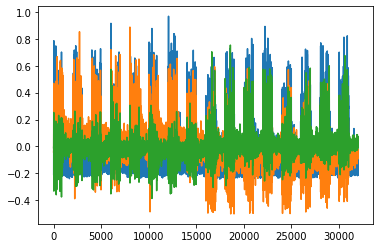

In [127]:
## Principal component analysis
## https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


##Try what you did regarding the hyperparameters here on PCA...

model=PCA(n_components=num_components, copy=True, whiten=False, 
                          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

model.fit(X)
print('Explained variance ratio: ',model.explained_variance_ratio_)
print('Singular values: ', model.singular_values_)

X_pca=model.transform(X)

plt.plot(X_pca)

Components:  [[ 0.00784811  0.03885713  0.03557283 -0.00473743 -0.00869259 -0.00548779
  -0.00572946  0.01168255  0.01418068]
 [ 0.00295538  0.00895806  0.01103428 -0.00265239 -0.00509944  0.005366
  -0.03475902  0.01458731 -0.00231361]
 [-0.00995513  0.01508247  0.01094466 -0.02271144 -0.01604662 -0.01871606
  -0.00302719 -0.01273902  0.00291724]]
Mixing values:  [[  6.12604827  -1.30613218  -9.60417578]
 [ 12.43836285  -3.06143448   0.71163172]
 [ 11.39452993  -0.94488187  -1.1814226 ]
 [  5.32371459  -3.3779219  -16.14938144]
 [  2.0265169   -3.26493293 -10.17250232]
 [  1.27474404   3.5789419  -11.90779397]
 [  8.62378045 -25.67708902  -4.77941727]
 [  5.3732864    6.23961683 -11.47670726]
 [  7.03317582  -5.7777326   -2.38610628]]
Mean values:  [0.08552499 0.04844104 0.07117152 0.11185034 0.0536936  0.10608485
 0.14986481 0.08273883 0.07012631]


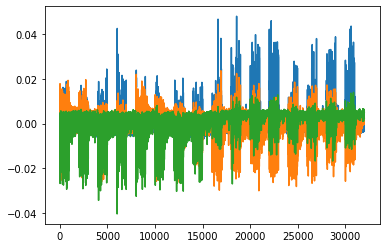

In [8]:
#Independent component analysis
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

model=FastICA(n_components=num_components, algorithm='parallel', whiten=True, 
        fun='logcosh', fun_args=None, max_iter=200, 
        tol=0.0001, w_init=None, random_state=None)
model.fit(X)
print('Components: ',model.components_)
print('Mixing values: ', model.mixing_)
print('Mean values: ', model.mean_)

X_ica=model.transform(X)

plt.plot(X_ica)

Variance accounted for:  0.7598955260111504


<AxesSubplot:>

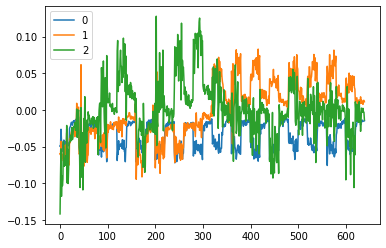

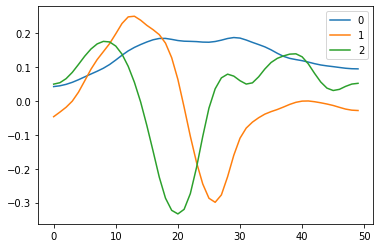

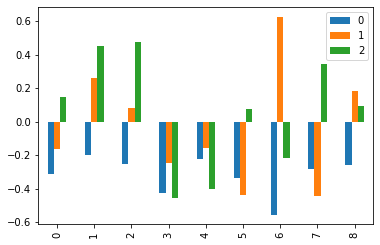

In [9]:
##Tensor decompositions: Tucker-2 decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

X_tensor=tl.tensor(abs(X).values.reshape(640,50,9))

core, factors_tuck = tucker(X_tensor ,rank=[num_components,num_components,num_components])
tucker_recon=tucker_to_tensor([core, factors_tuck])

SSE=np.sum(np.linalg.norm((X_tensor-tucker_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_tuck=1-SSE/SST
print('Variance accounted for: ',VAF_tuck)

pd.DataFrame(factors_tuck[0]).plot()
pd.DataFrame(factors_tuck[1]).plot()
pd.DataFrame(factors_tuck[2]).plot(kind='bar')

Variance accounted for:  0.6649510380241694


<AxesSubplot:>

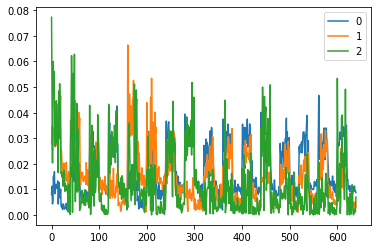

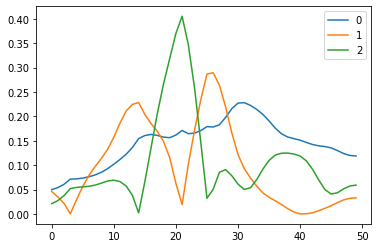

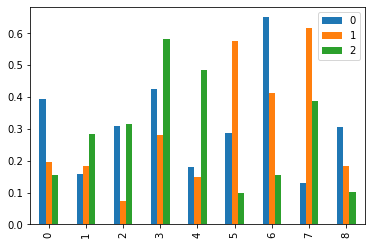

In [10]:
##Tensor decompositions: Non-negative Tucker-2
##http://tensorly.org/stable/user_guide/tensor_decomposition.html
X_tensor=tl.tensor(abs(X).values.reshape(640,50,9))
core, factors_nnt =non_negative_tucker(X_tensor ,rank=[num_components,num_components,num_components])

tucker_recon=tucker_to_tensor([core, factors_nnt])

SSE=np.sum(np.linalg.norm((X_tensor-tucker_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_nnt=1-SSE/SST
print('Variance accounted for: ',VAF_nnt)

pd.DataFrame(factors_nnt[0]).plot()
pd.DataFrame(factors_nnt[1]).plot()
pd.DataFrame(factors_nnt[2]).plot(kind='bar')

Variance accounted for:  0.7491972325204577


<AxesSubplot:>

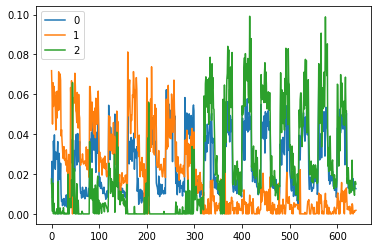

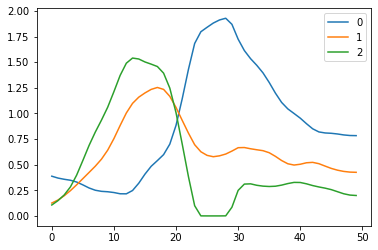

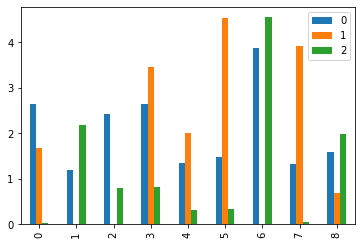

In [11]:
##Tensor decompositions: PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html
X_tensor=tl.tensor(abs(X).values.reshape(640,50,9))
factors_para = non_negative_parafac(X_tensor ,rank=num_components)
parafac_recon=tl.cp_to_tensor(factors_para)
SSE=np.sum(np.linalg.norm((X_tensor-parafac_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_para=1-SSE/SST
print('Variance accounted for: ',VAF_para)

pd.DataFrame(factors_para[1][0]).plot()
pd.DataFrame(factors_para[1][1]).plot()
pd.DataFrame(factors_para[1][2]).plot(kind='bar')

In [259]:
## Decode the task using the underlying parameters trial-specific coefficients from the above tensor decompositions
## For the Task1-16 variable, a decoding accuracy >1/16 is significant and so on for the other variables.
## https://www.frontiersin.org/articles/10.3389/fncom.2013.00008



LDA Accuracy score:  0.9791666666666666


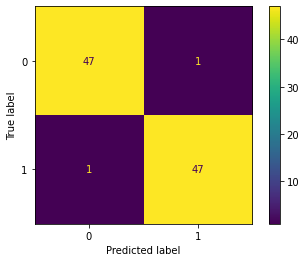

Naive Bayes Accuracy score:  0.9791666666666666


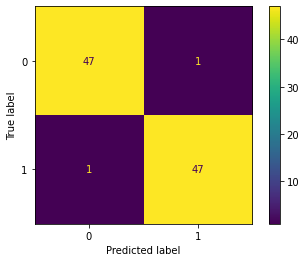

K-Nearest Neighbors Accuracy score:  0.9791666666666666


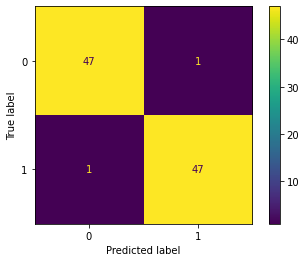

In [128]:
#Tucker decomposition
X_train, X_test, y_train, y_test=train_test_split(factors_tuck[0],task,train_size=0.85,stratify=task)

model=LDA()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_tuck=accuracy_score(y_test,y_pred)
plot_confusion_matrix(model,X_test,y_test)
plt.show()

#Naive-Bayes
#https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print('Naive Bayes Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()


##K-Nearest Neighbors
##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
knn=KNN(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print('K-Nearest Neighbors Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(knn ,X_test,y_test)
plt.show()

LDA Accuracy score:  0.7395833333333334


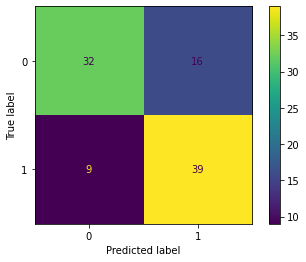

Naive Bayes Accuracy score:  0.6666666666666666


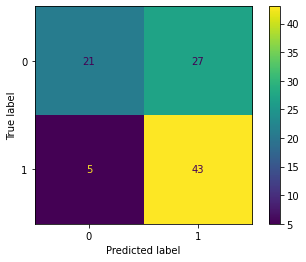

K-Nearest Neighbors Accuracy score:  0.8125


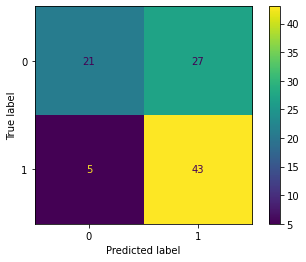

In [129]:
##Non-negative Tucker decomposition
X_train, X_test, y_train, y_test=train_test_split(factors_nnt[0],task,train_size=0.85,stratify=task)

model=LDA()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_nnt=accuracy_score(y_test,y_pred)
plot_confusion_matrix(model,X_test,y_test)
plt.show()

#Naive-Bayes
#https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print('Naive Bayes Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()


##K-Nearest Neighbors
##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
knn=KNN(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print('K-Nearest Neighbors Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()

LDA Accuracy score:  0.9791666666666666


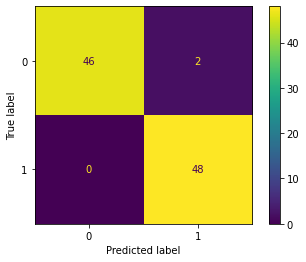

Naive Bayes Accuracy score:  0.9791666666666666


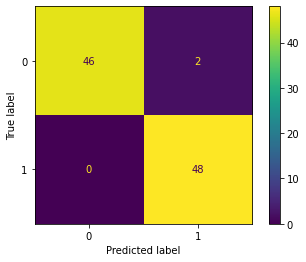

K-Nearest Neighbors Accuracy score:  0.9791666666666666


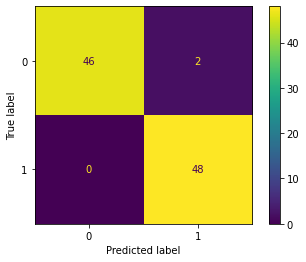

In [130]:
##Parafac-decomposition
X_train, X_test, y_train, y_test=train_test_split(factors_para[1][0],task,train_size=0.85,stratify=task)

model=LDA()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_para=accuracy_score(y_test,y_pred)
plot_confusion_matrix(model,X_test,y_test)
plt.show()

#Naive-Bayes
#https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print('Naive Bayes Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()


##K-Nearest Neighbors
##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
knn=KNN(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print('K-Nearest Neighbors Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(knn ,X_test,y_test)
plt.show()

In [131]:
##Can you find the model that gives the best output in terms of the VAF vs Task-decoding trade-off??
## https://www.frontiersin.org/articles/10.3389/fncom.2013.00008

print('Tucker decomposition: ', VAF_tuck*LDA_acc_tuck)
print('Non-negative Tucker decomposition: ', VAF_nnt*LDA_acc_nnt)
print('PARAFAC decomposition: ', VAF_para*LDA_acc_para)

Tucker decomposition:  0.7440643692192515
Non-negative Tucker decomposition:  0.4917867052053753
PARAFAC decomposition:  0.7335889568429481


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Accuracy score:  0.6354166666666666


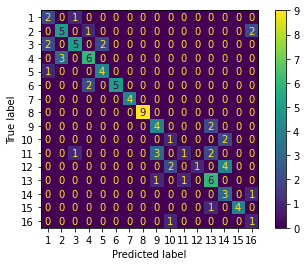

In [390]:
##Deep learning##

##Below you can find the code setup for a multi-layer perceptron (MLP_, the simplest form of neural network.
##Who's output layer is applicable to classification problems


##Pick the output from a tensor decomposition to use as input into the MLP, set Type=1 for Tucker, 2 for Non-negative tucker
##and 3 for PARAFAC. Note that the MLP is sensitive to the magnitude of the input variables and therefore it is necessary to
##standardise them


##Look across the web for a general rule for how many layers and nodes one should have in a neural network and see if it
##produces the best results here.


Type=1

if Type==1:
    X_mlp=factors_tuck[0]
elif Type==2:
    X_mlp=factors_nnt[0]
else:
    X_mlp=factors_para[1][0]

    
scaler= StandardScaler()


X_train, X_test, y_train, y_test=train_test_split(X_mlp,task.values,train_size=0.85)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(75,25), random_state=1)

clf.fit(X_train, y_train)

y_preds=clf.predict(X_test)
print('MLP Accuracy score: ',accuracy_score(y_test,y_preds))
plot_confusion_matrix(clf ,X_test,y_test)
plt.show()

In [436]:
##Try to construct your own neural network that can classify the right reaching task...here is an example using the Keras framework
##https://keras.io/

##Pick the output from a tensor decomposition to use as input into the MLP, set Type=1 for Tucker, 2 for Non-negative tucker
##and 3 for PARAFAC. Note that the neural network is sensitive to the magnitude of the input variables and therefore it is necessary to
##standardise them

Type=3

if Type==1:
    X_NN=factors_tuck[0]
elif Type==2:
    X_NN=factors_nnt[0]
else:
    X_NN=factors_para[1][0]

    
##This neural network cannot take multiple classes as a target variable, therefore we must encode the target variable
##as a set of binary integers
# encode class values as integers


if task.name=='Task':
    encoder = LabelEncoder()
    encoder.fit(task)
    encoded_Y = encoder.transform(task)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_Y)
    X_train, X_test, y_train, y_test=train_test_split(X_NN,dummy_y,train_size=0.85)
else:
    X_train, X_test, y_train, y_test=train_test_split(X_NN,task.values,train_size=0.85)
    
##As with the MLP above, the neural network is sensitive to differences in magnitude between predictor variables that may not
##necessarily be informative...therefore we will scale the input data accordingly
scaler= StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)





##Here are some parameters you can adjust to optimise the neural network, how do these adjustments effect the output??:

#The number of neurons in the layer
#The number of layers
#The activation function
#The loss function
#The optimizer
#The metrics
#The training epochs
#The batch size
#The number of cross-validations




def NeuralNet_model():
# create model
    model = Sequential()
    model.add(Dense(50, input_dim=num_components, activation='relu'))
    #model.add(Dense(50, input_dim=num_components, activation='relu'))
    model.add(Dense(np.unique(task)[-1], activation='softmax'))
# Compile model
    model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train,y_train)
    return model

estimator = KerasClassifier(build_fn=NeuralNet_model, epochs=200, batch_size=1, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_test, y_test, cv=kfold)
print("Cross validated score (Mean (Std)): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

17/17 [==============================] - 0s 527us/step - loss: 0.0000e+00 - accuracy: 0.4890
Cross validated score (Mean (Std)): 56.26% (6.15%)
